# Example for creating family of Halo via Natural Parameter Continuation

Yuri Shimane

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#import plotly.express as px
import pandas as pd
from tqdm.notebook import tqdm

%matplotlib notebook

In [2]:
import sys
sys.path.append('../')   # path to polaris module

import polaris.SolarSystemConstants as sscs
import polaris.Keplerian as kepl
import polaris.Propagator as prop
import polaris.R3BP as r3bp

In [3]:
param_earth_moon = r3bp.get_cr3bp_param('399','301')   # NAIF ID's '399': Earth, '301': Moon
lp = r3bp.lagrangePoints(param_earth_moon.mu)
param_earth_moon.mu

0.012150584269940354

In [4]:
param_earth_moon

In [5]:
# initial member
# state0  = np.array([1.16935708791412, 0.0, 0.096785570098781, 0.0, -0.19393150190919, 0.0])
# period0 = 3.33357641283143

period0 = 3.414576412831317
state0 = np.array([1.180784443687683, 0.0, -0.010805680495889, 0.0, -0.156530350055154, 0.0])

# initialize list and append initial member
proplst = []
proplst.append( prop.propagate_cr3bp(param_earth_moon, state0, period0) )

# setup array of periods to use
step_period = - 0.00065
stop_period = 1.5  #period0 - 1.4
periods = np.arange(period0, stop_period, step_period)

len(periods), stop_period

(2946, 1.5)

In [8]:
# initialize pandas dataframe
df_keys = ["System", "Family", "mu", "Period", "Jacobi", "Stability", 
           "state_x", "state_y", "state_z", "state_vx", "state_vy", "state_vz",]
famdf = pd.DataFrame( columns=df_keys )
solcount = 0   # number of solutions

# run single shooting
state_iter = state0
p_iter     = period0
for period in tqdm(periods):
    p_iter, state_iter, conv_iter = r3bp.ssdc_periodic_xzplane(param_earth_moon, state_iter, period, 
                                                               fix="period", message=False)
    if conv_iter==1:
        # store propagation output for plotting
        proptmp = prop.propagate_cr3bp(param_earth_moon, state_iter, p_iter, stm_option=True)
        proplst.append( proptmp )
        monodromy = np.reshape( proptmp.stms[:,-1] , (6,6) )
        # store solution into dataframe
        snew = pd.Series(["Earth_Moon",
                          "l2_halo_southern",
                          param_earth_moon.mu,
                          p_iter,
                          r3bp.jacobiConstant(param_earth_moon.mu, state_iter),
                          r3bp.stabilityIndex(monodromy), 
                          state_iter[0], state_iter[1], state_iter[2], 
                          state_iter[3], state_iter[4], state_iter[5] ], index=df_keys, name=int(solcount))
        famdf = pd.DataFrame.append(famdf, snew)
        solcount += 1
    else:
        print(f'Breaking at {period}!')
        break

  0%|          | 0/2946 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


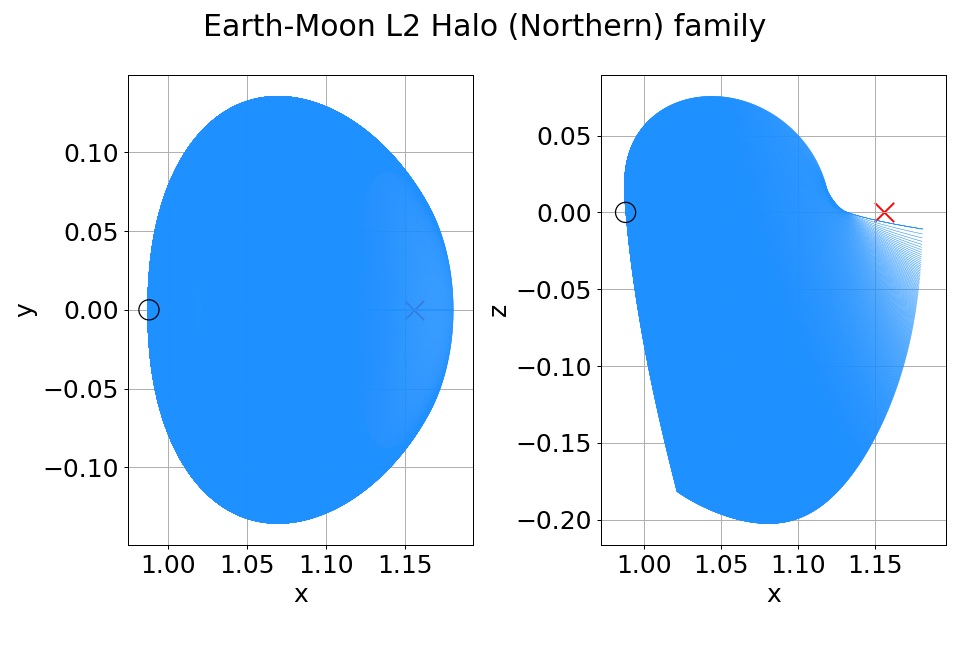

  0%|          | 0/2949 [00:00<?, ?it/s]

In [9]:
# plot resulting family
plt.rcParams["font.size"] = 20
fig, axs = plt.subplots(1, 2, figsize=(12,8))

for propout in tqdm(proplst):
    axs[0].plot(propout.xs, propout.ys, linewidth=0.4, c='dodgerblue', alpha=0.55)
    axs[1].plot(propout.xs, propout.zs, linewidth=0.4, c='dodgerblue', alpha=0.55)
    
for idx in range(2):
    axs[idx].grid(True)
    axs[idx].axis("equal")
    axs[idx].scatter(1-param_earth_moon.mu, 0., marker='o', facecolor="none", edgecolor='k', zorder=3, s=260, label='Moon')
    axs[idx].scatter(lp.l2[0], lp.l2[1], marker='x', c='r', s=240)

axs[0].set(xlabel="x", ylabel="y")
axs[1].set(xlabel="x", ylabel="z")

plt.suptitle('Earth-Moon L2 Halo (Northern) family')
plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.show()

In [10]:
famdf

,System,Family,mu,Period,Jacobi,Stability,state_x,state_y,state_z,state_vx,state_vy,state_vz
0,Earth_Moon,l2_halo_southern,0.012151,3.414576,3.151607,600.775901,1.180784,0.0,-0.010806,0.0,-0.156530,0.0
1,Earth_Moon,l2_halo_southern,0.012151,3.413926,3.151259,597.172483,1.180706,0.0,-0.014008,0.0,-0.156985,0.0
2,Earth_Moon,l2_halo_southern,0.012151,3.413276,3.150912,593.594106,1.180627,0.0,-0.016602,0.0,-0.157435,0.0
3,Earth_Moon,l2_halo_southern,0.012151,3.412626,3.150566,590.040580,1.180548,0.0,-0.018840,0.0,-0.157882,0.0
4,Earth_Moon,l2_halo_southern,0.012151,3.411976,3.150221,586.511718,1.180469,0.0,-0.020839,0.0,-0.158325,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2941,Earth_Moon,l2_halo_southern,0.012151,1.502926,3.047122,1.305483,1.021401,0.0,-0.181665,0.0,-0.101900,0.0
2942,Earth_Moon,l2_halo_southern,0.012151,1.502276,3.047172,1.304093,1.021351,0.0,-0.181631,0.0,-0.101792,0.0
2943,Earth_Moon,l2_halo_southern,0.012151,1.501626,3.047222,1.302702,1.021302,0.0,-0.181596,0.0,-0.101684,0.0
2944,Earth_Moon,l2_halo_southern,0.012151,1.500976,3.047271,1.301308,1.021253,0.0,-0.181562,0.0,-0.101576,0.0


<IPython.core.display.Javascript object>


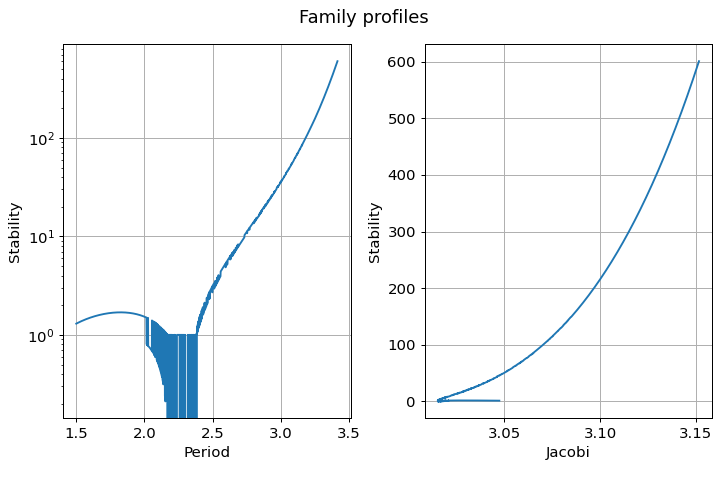

In [14]:
plt.rcParams["font.size"] = 12
fig, axs = plt.subplots(1, 2, figsize=(9,6))
axs[0].semilogy(famdf["Period"], famdf["Stability"])
axs[0].set(xlabel="Period", ylabel="Stability")
axs[0].grid(True)

axs[1].plot(famdf["Jacobi"], famdf["Stability"])
axs[1].set(xlabel="Jacobi", ylabel="Stability")
axs[1].grid(True)

plt.suptitle('Family profiles')
plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.show()

### Save resulting family into JSON file

In [ ]:
raise SystemExit("Stop before saving!")

In [ ]:
# save output
flename = "l2_halo_southern_test.json"
pathjson = '../data/r3bp/Earth_Moon/' + flename
famdf.to_json(pathjson, orient='index', indent=4, double_precision=15)

print(f'Done! Saved at {pathjson}')